In [69]:
%matplotlib widget

In [1]:
greyscale=['#000000','#0F0F0F','#3D3D3D','#6B6B6B','#7A7A7A','#999999','#C7C7C7','#D6D6D6']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']
#['#D9008E','#0000D2','#8400D6','#0048D1','#00C6CF','#21E121','#B5F23C','#3900D4']

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from sklearn.preprocessing import StandardScaler
from ephysvibe.task import task_constants
import pca_tools
seed=2024

### Define functions

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz

### Read data

In [5]:
# Load data
avgwin = 100
min_sp_sec = 5
n_test = 1
min_trials = 10
# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400
# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# -------------------------------------------- End parameters ------------------------------------------
# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test

# Define epochs
part1 = end_sample-start_sample
test1_st = part1-start_test
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d1 = np.arange(200+450,part1,2)
idx_d2 = np.arange(part1,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,trial_dur,2)

In [6]:
# part 1 
t_epochs1 = {'fixation':idx_f,'sample':idx_s,'delay':idx_d1}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors1 = {'epochs':{'fixation':colors_g[0],'sample':colors_g[2],'delay':colors_g[4]}}
colors_neu1 = {'epochs':{'fixation':greyscale[0],'sample':greyscale[2],'delay':greyscale[4]}}#
# part 2 
t_epochs2 = {'delay':idx_d2,'test1':idx_t1,'test off':idx_aftert}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors2 = {'epochs':{'delay':colors_g[4],'test1':colors_g[6],'test2':colors_g[6],'test3':colors_g[6],'test4':colors_g[6],'test off':colors_g[-1]}}
colors_neu2 = {'epochs':{'delay':greyscale[4],'test1':greyscale[6],'test2':greyscale[5],'test3':greyscale[5],'test4':greyscale[5],'test off':greyscale[-1]}}#

In [7]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/"
    )
elif platform.system() == "Windows":
    basepath = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'

save=False
savepath = './res/'
save_format = 'svg'

In [70]:
# allpath = {'v4':'/envau/work/invibe/USERS/LOSADA/Users/losadac/pca/test/v4/2024-06-06_15-00-01/v4_win100_test1_nonmatchTrue_min10tr_pca.h5',
#            'lip':'/envau/work/invibe/USERS/LOSADA/Users/losadac/pca/test/lip/2024-06-06_12-38-40/lip_win100_test1_nonmatchTrue_min10tr_pca.h5',
#            'pfc':'/envau/work/invibe/USERS/LOSADA/Users/losadac/pca/test/pfc/2024-06-06_14-53-27/pfc_win100_test1_nonmatchTrue_min10tr_pca.h5'}
allpath = {'lip':'lip_win100_test1_nonmatchTrue_min10tr_pca.h5'}


In [71]:
n_comp=50
pc_areas = {}
for area,path in allpath.items():#'lip',
    fr = from_python_hdf5(path)[0]# basepath+area+'/align_epochs/'+area+'_win50_test'+str(n_test)+'_wnonmatch_min10tr_pca.h5'
    fr_concat = np.concatenate((fr['0mean'],fr['11mean'],fr['15mean'],fr['51mean'],fr['55mean']),axis=1)

    #fr_concat = z_score(fr_concat,with_std=False)
    model,pc_s = pca_tools.compute_pca(fr_concat,n_comp=n_comp)

    print('%s %d'%(area,fr_concat.shape[0]))
    
    pc_areas[area] = {'model':model,'pc':pc_s,'n_neurons':fr_concat.shape[0]}


lip 423


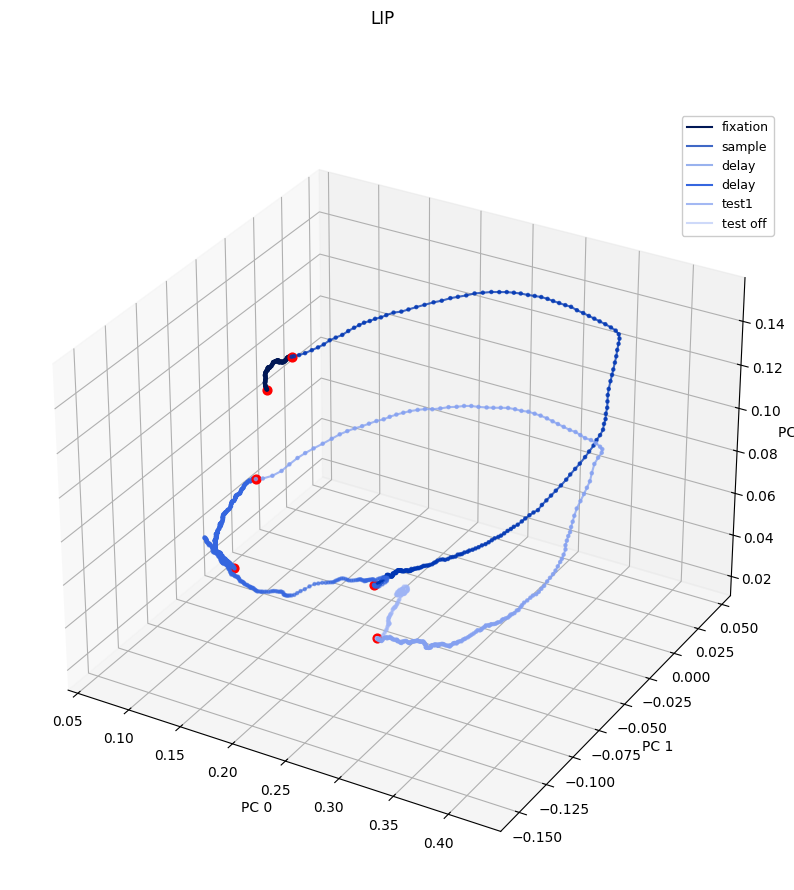

In [72]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,trial_dur)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    fig, ax = plt.subplots(
        figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    pca_tools.plot_pc_3d(mean_pc_s,colors1,t_epochs1,key,fig=fig,ax=ax,sample_flag = False)
    pca_tools.plot_pc_3d(mean_pc_s,colors2,t_epochs2,key,fig=fig,ax=ax,sample_flag = False)

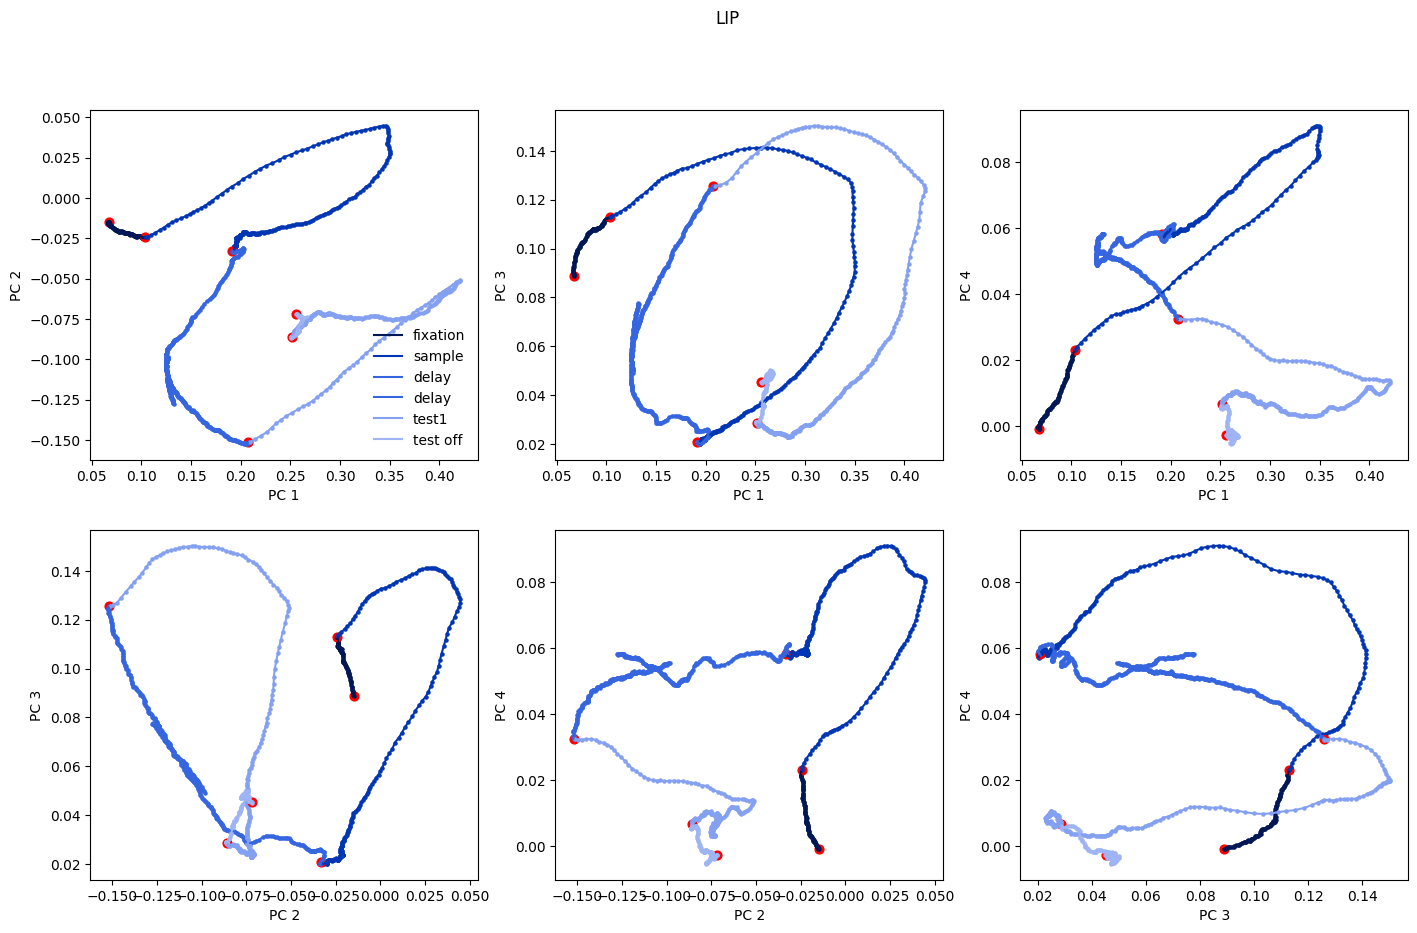

In [73]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,trial_dur)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    pca_tools.plot_pc(mean_pc_s,colors1,t_epochs1,key,sample_flag = False,fig=fig, ax=ax,idot=0)
    pca_tools.plot_pc(mean_pc_s,colors2,t_epochs2,key,sample_flag = False,fig=fig, ax=ax,idot=-1)
    if save:
        figname = key+'_pcs_sample_mean.'+save_format
        fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

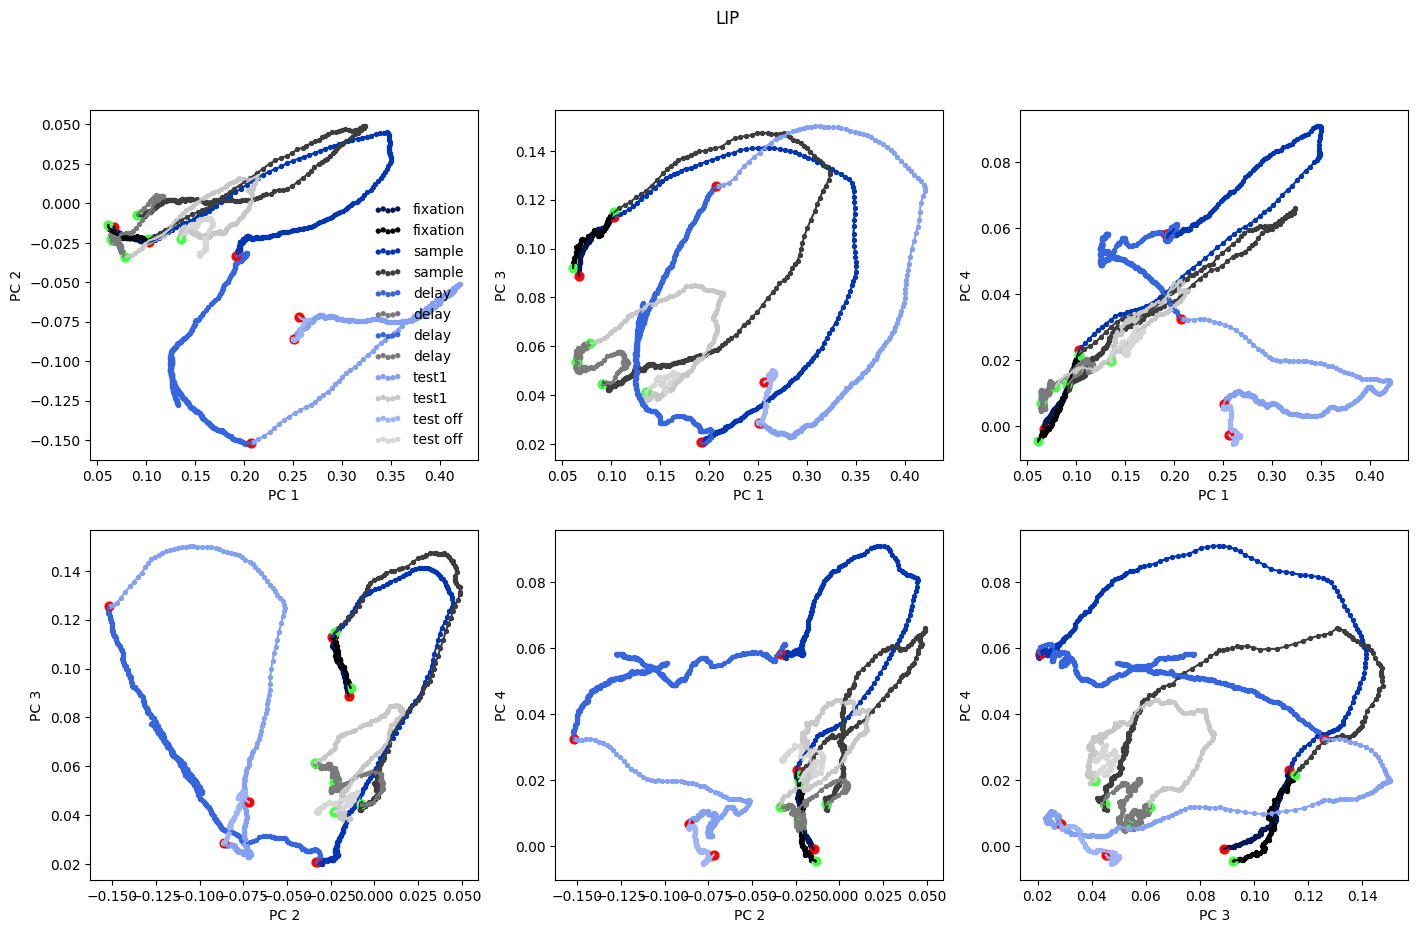

In [74]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,trial_dur)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors1,colors_neu1,t_epochs1,key,fig=fig, ax=ax ,idot=0)
    pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors2,colors_neu2,t_epochs2,key,fig=fig , ax=ax,idot=-1)
    if save:
        figname = key+'_pcs_neutral_sample.'+save_format
        fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

In [75]:
samples={
    "0": 0,
    "11": 1,
    "15": 2,
    "55": 3,
    "51": 4,   
}
light_colors = {    "11": "#E45454",  
    "15": "#60B2B2",  
    "51": "#FFA08B",  
    "55": "#7EEBE5",  
    "0": "#BFBFBF",}

In [76]:
colors_s = []
for i_sample in samples.keys():
    colors_s.append({'sample':i_sample,'epochs':{'fixation': task_constants.PALETTE_B1[i_sample],
    'sample': task_constants.PALETTE_B1[i_sample],
    'delay': task_constants.PALETTE_B1[i_sample],
    'test1': task_constants.PALETTE_B1[i_sample],
    'test2': task_constants.PALETTE_B1[i_sample],
    'test3': task_constants.PALETTE_B1[i_sample],
    'test4': task_constants.PALETTE_B1[i_sample],
    'test off': task_constants.PALETTE_B1[i_sample]}})
colors_l = []
for i_sample in samples.keys():
    colors_l.append({'sample':i_sample,'epochs':{'fixation': light_colors[i_sample],
    'sample': light_colors[i_sample],
    'delay': light_colors[i_sample],
    'test1': light_colors[i_sample],
    'test2': light_colors[i_sample],
    'test3': light_colors[i_sample],
    'test4': light_colors[i_sample],
    'test off': light_colors[i_sample]}})

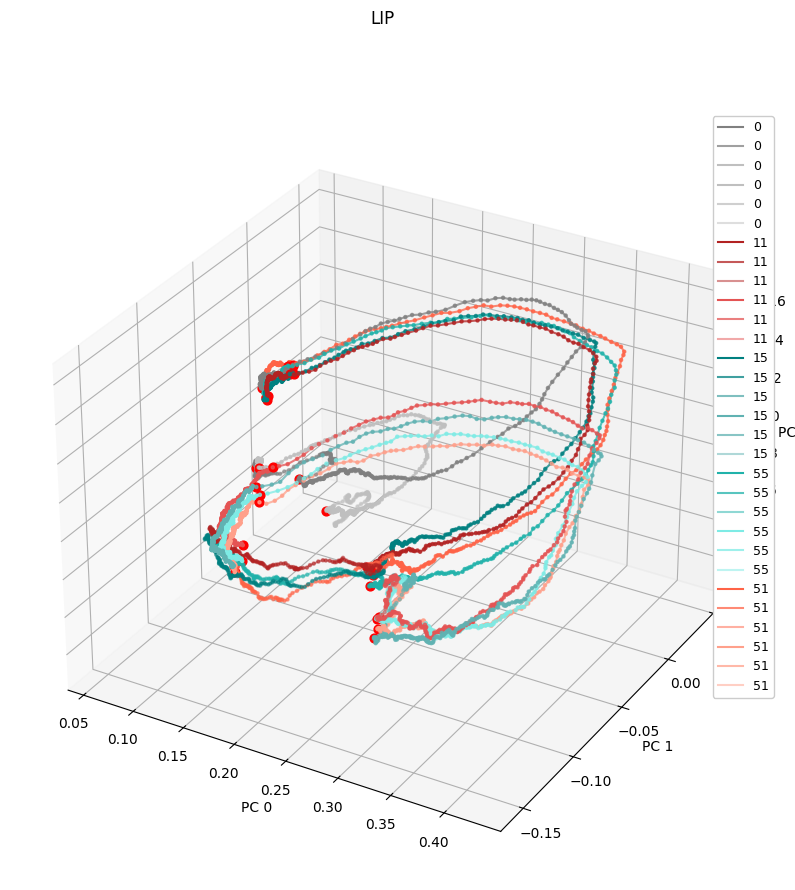

In [77]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,trial_dur)
    fig, ax = plt.subplots(
        figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    for s in range(5):
        pca_tools.plot_pc_3d(reshape_pc_s[:,s],colors_s[s],t_epochs1,key,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)
        pca_tools.plot_pc_3d(reshape_pc_s[:,s],colors_l[s],t_epochs2,key,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)

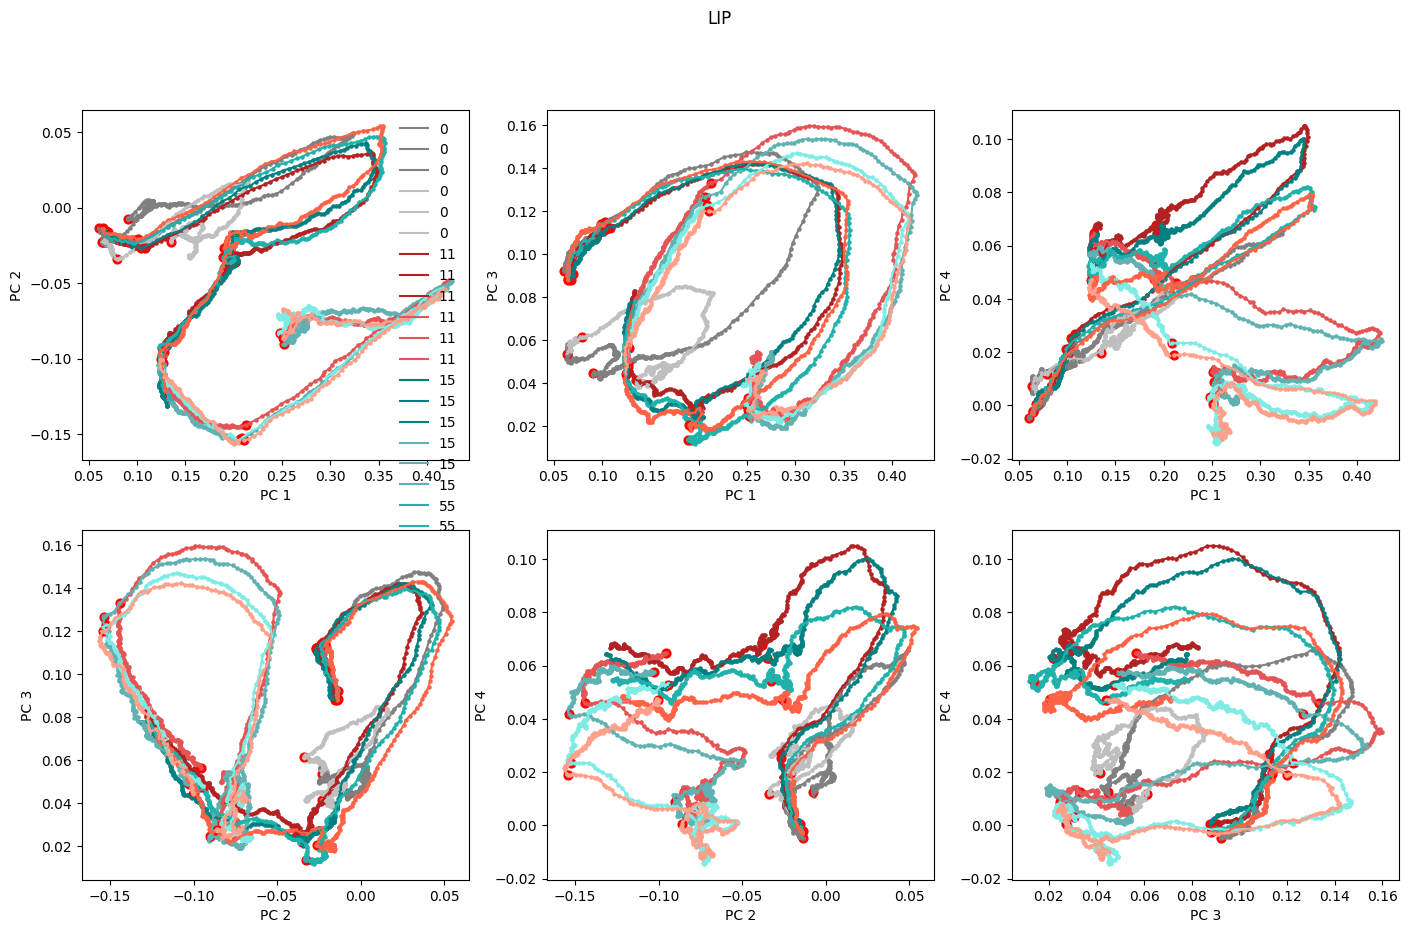

In [85]:
for area in pc_areas:
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,trial_dur)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    for s in range(5):
        pca_tools.plot_pc(reshape_pc_s[:,s],colors_s[s],t_epochs1,area,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)
        pca_tools.plot_pc(reshape_pc_s[:,s],colors_l[s],t_epochs2,area,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)
    if save:
        figname = 'pcs_vs_pcs_'+area+'.'+save_format
        fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

lip: 4 components to explain 80% of the variance


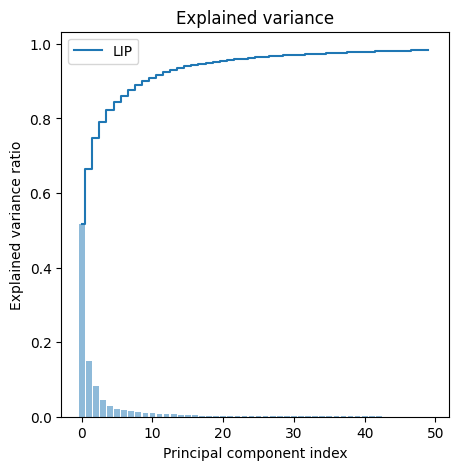

In [86]:
fig, ax = plt.subplots(figsize=(5,5))
for key in pc_areas:
    pca_tools.plot_explained_var(pc_areas[key]['model'],figsize=(5,5),area=key,fig=fig,ax=ax)
if save:
    figname = 'explained_var.'+save_format
    fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

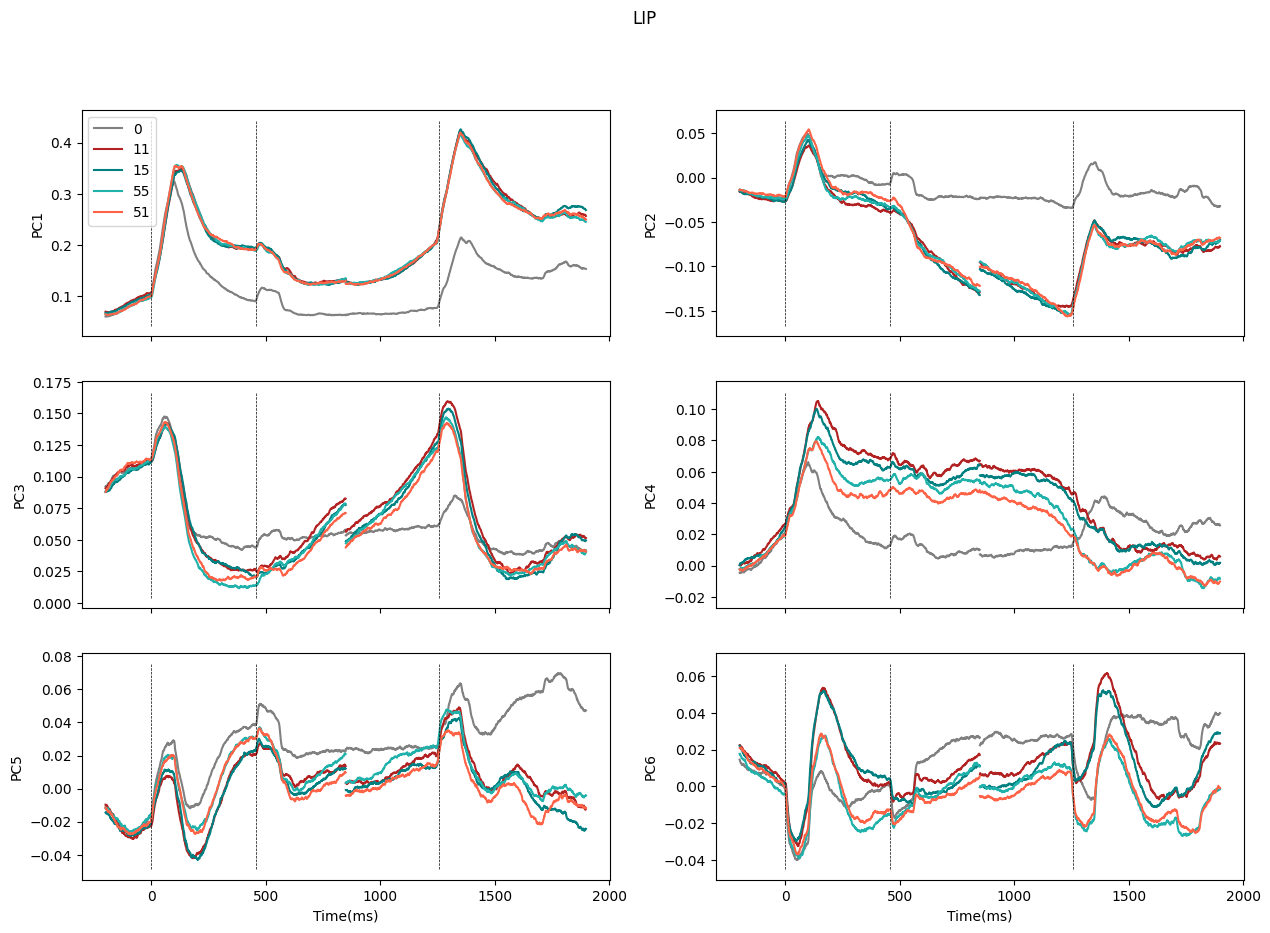

In [87]:
for area in pc_areas:
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,trial_dur)
    f,ax=plt.subplots(3,2,figsize=(15,10),sharex=True)
    for i_sample in samples.keys():
        
        ax[0,0].plot((np.arange(trial_dur)-200)[:part1],reshape_pc_s[0,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[0,1].plot((np.arange(trial_dur)-200)[:part1],reshape_pc_s[1,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[1,0].plot((np.arange(trial_dur)-200)[:part1],reshape_pc_s[2,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[1,1].plot((np.arange(trial_dur)-200)[:part1],reshape_pc_s[3,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[2,0].plot((np.arange(trial_dur)-200)[:part1],reshape_pc_s[4,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[2,1].plot((np.arange(trial_dur)-200)[:part1],reshape_pc_s[5,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

        ax[0,0].plot((np.arange(trial_dur)-200)[part1:],reshape_pc_s[0,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[0,1].plot((np.arange(trial_dur)-200)[part1:],reshape_pc_s[1,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[1,0].plot((np.arange(trial_dur)-200)[part1:],reshape_pc_s[2,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[1,1].plot((np.arange(trial_dur)-200)[part1:],reshape_pc_s[3,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[2,0].plot((np.arange(trial_dur)-200)[part1:],reshape_pc_s[4,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[2,1].plot((np.arange(trial_dur)-200)[part1:],reshape_pc_s[5,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])

    ax[0,0].vlines([0,458,1258],ax[0,0].get_ylim()[0],ax[0,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[0,1].vlines([0,458,1258],ax[0,1].get_ylim()[0],ax[0,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[1,0].vlines([0,458,1258],ax[1,0].get_ylim()[0],ax[1,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[1,1].vlines([0,458,1258],ax[1,1].get_ylim()[0],ax[1,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[2,0].vlines([0,458,1258],ax[2,0].get_ylim()[0],ax[2,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[2,1].vlines([0,458,1258],ax[2,1].get_ylim()[0],ax[2,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)

    ax[0,0].set(ylabel='PC1')
    ax[0,1].set(ylabel='PC2')
    ax[1,0].set(ylabel='PC3')
    ax[1,1].set(ylabel='PC4')
    ax[2,0].set(xlabel='Time(ms)',ylabel='PC5')
    ax[2,1].set(xlabel='Time(ms)',ylabel='PC6')
    ax[0,0].legend()
    f.suptitle(area.upper())

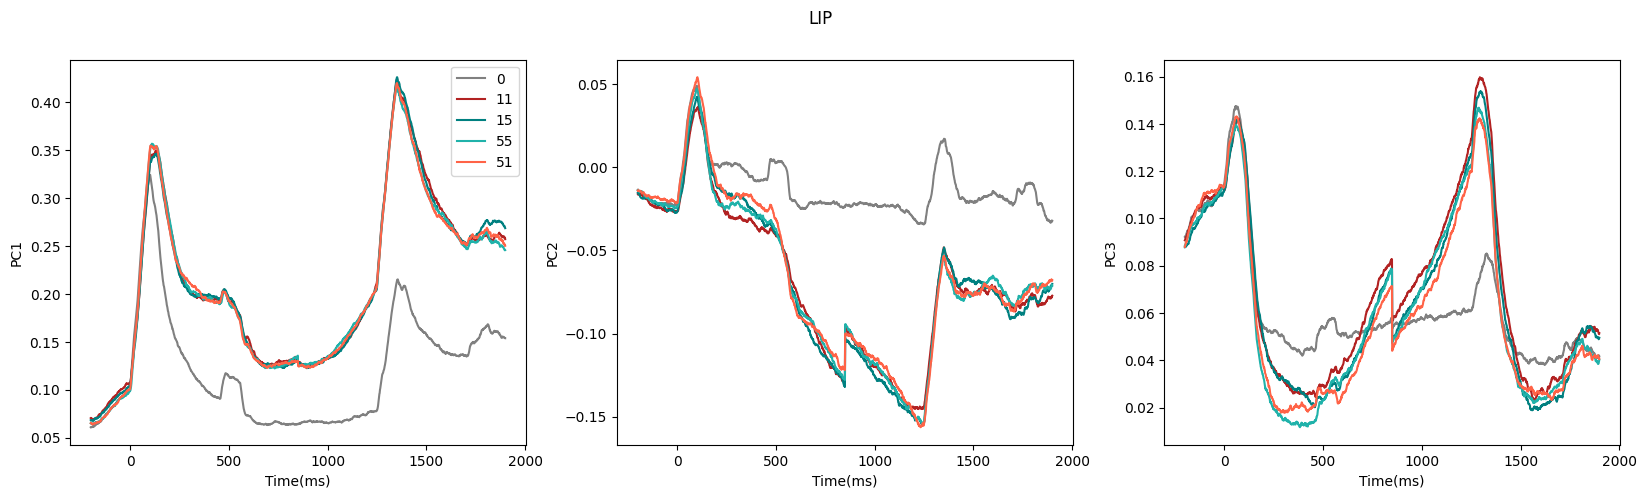

In [88]:
for area in pc_areas:
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,trial_dur)
    f,ax=plt.subplots(1,3,figsize=(20,5))
    for i_sample in samples.keys():
        
        ax[0].plot(np.arange(trial_dur)-200,reshape_pc_s[0,samples[i_sample],:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        #ax[0].vlines(850,0,0.5)
        ax[1].plot(np.arange(trial_dur)-200,reshape_pc_s[1,samples[i_sample],:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[2].plot(np.arange(trial_dur)-200,reshape_pc_s[2,samples[i_sample],:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[0].set(xlabel='Time(ms)',ylabel='PC1')
        ax[1].set(xlabel='Time(ms)',ylabel='PC2')
        ax[2].set(xlabel='Time(ms)',ylabel='PC3')
    ax[0].legend()
    f.suptitle(area.upper())
    if save:
        figname = 'pcs_vs_time_'+area+'.'+save_format
        f.savefig(savepath+figname,format=save_format,bbox_inches="tight")

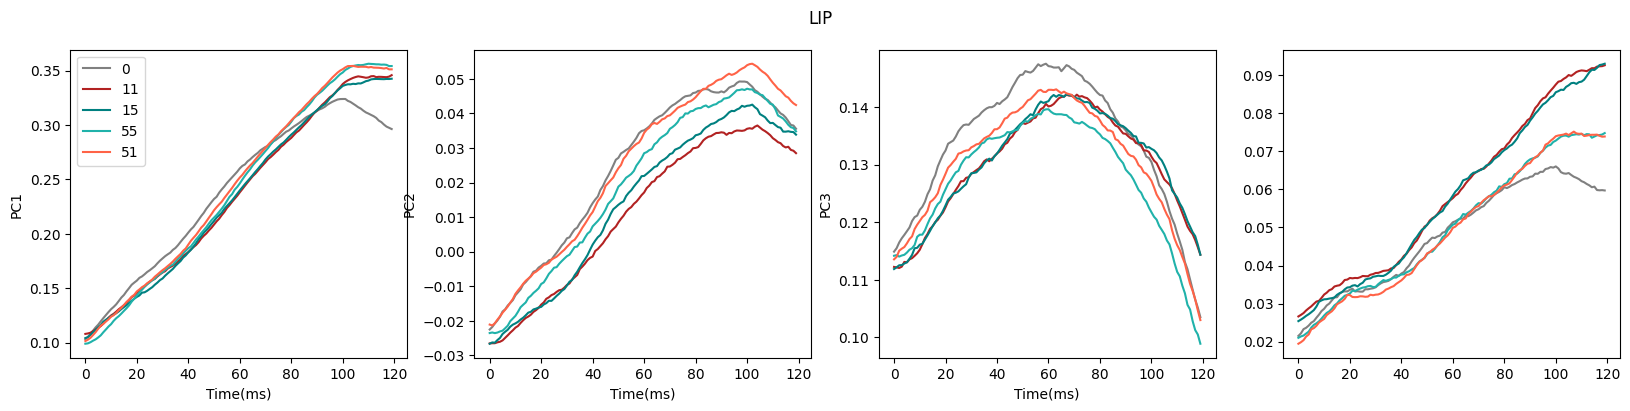

In [89]:
for area in pc_areas:
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,trial_dur)
    f,ax=plt.subplots(1,4,figsize=(20,4))
    for i_sample in samples.keys():
        ax[0].plot(np.arange(120),reshape_pc_s[0,samples[i_sample],200:320],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[1].plot(np.arange(120),reshape_pc_s[1,samples[i_sample],200:320],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[2].plot(np.arange(120),reshape_pc_s[2,samples[i_sample],200:320],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[3].plot(np.arange(120),reshape_pc_s[3,samples[i_sample],200:320],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[0].set(xlabel='Time(ms)',ylabel='PC1')
    ax[1].set(xlabel='Time(ms)',ylabel='PC2')
    ax[2].set(xlabel='Time(ms)',ylabel='PC3')
    ax[0].legend()
    f.suptitle(area.upper())


In [90]:
i_sample

'51'

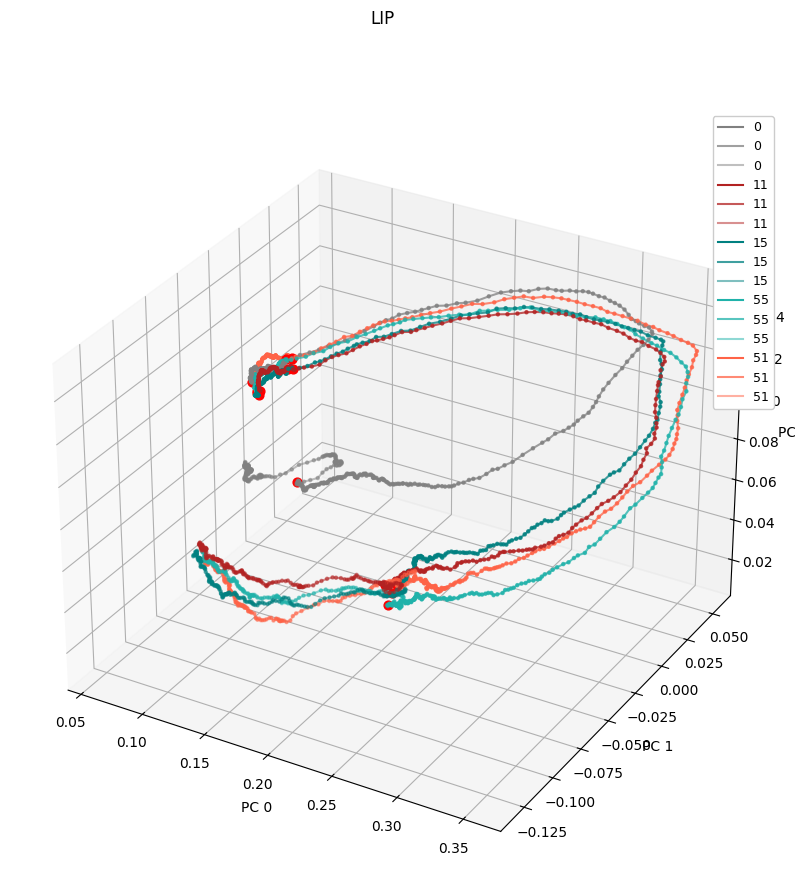

In [91]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,trial_dur)
    fig, ax = plt.subplots(
        figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    for s in range(5):
        pca_tools.plot_pc_3d(reshape_pc_s[:,s],colors_s[s],t_epochs1,key,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)